# Лабораторная 3. Линейная регрессия


## Импорт библиотек

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Загрузка данных

In [22]:
df = pd.read_csv("california_housing_train.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            17000 non-null  float64
 2   housing_median_age  17000 non-null  float64
 3   total_rooms         17000 non-null  float64
 4   total_bedrooms      17000 non-null  float64
 5   population          17000 non-null  float64
 6   households          17000 non-null  float64
 7   median_income       17000 non-null  float64
 8   median_house_value  17000 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


## 1. Получаем и визуализируем статистику по датасету

In [24]:
df.describe(include="all")

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578,207300.912353
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,1.908157,115983.764387
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1462.000000,297.000000,790.000000,282.000000,2.566375,119400.000000
50%,-118.490000,34.250000,29.000000,2127.000000,434.000000,1167.000000,409.000000,3.544600,180400.000000
75%,-118.000000,37.720000,37.000000,3151.250000,648.250000,1721.000000,605.250000,4.767000,265000.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### Гистограммы числовых признаков


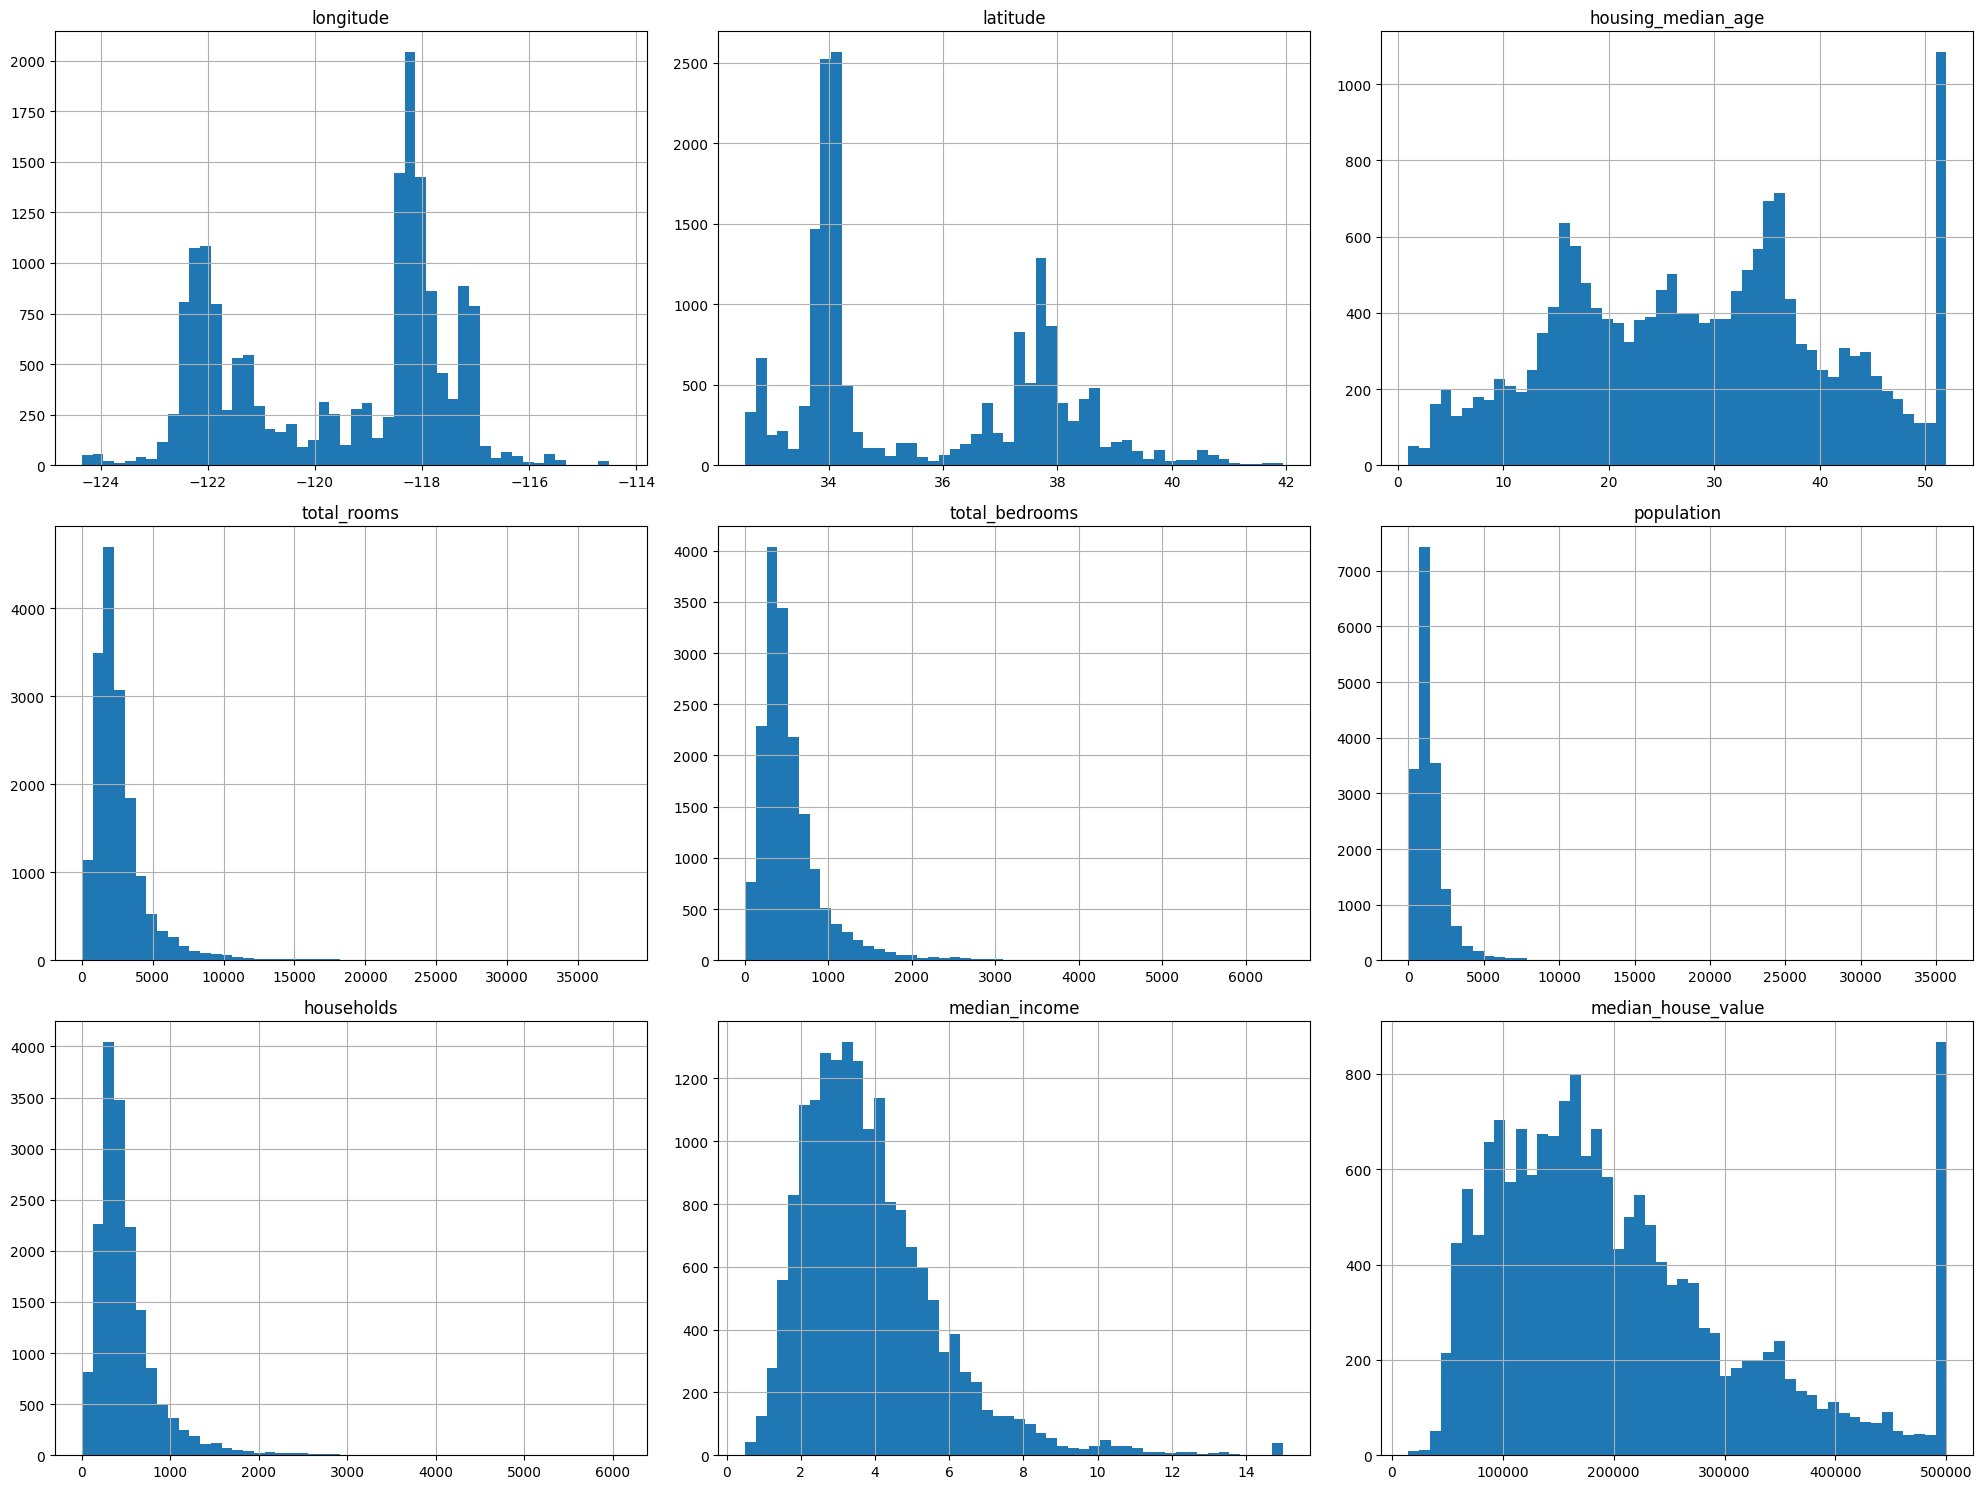

In [25]:
numeric_cols = df.columns

df[numeric_cols].hist(bins=50, figsize=(20, 15))
plt.tight_layout()
plt.show()

### Корреляционная матрица признаков


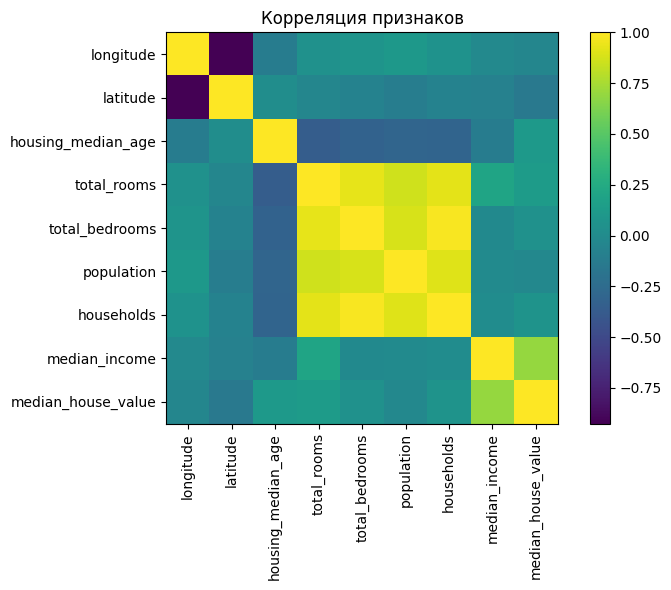

In [26]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap="viridis", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title("Корреляция признаков")
plt.tight_layout()
plt.show()

## 2. Предварительная обработка данных


### Обработка пропущенных значений

In [27]:
# смотрим, есть ли пропуски
df.isnull().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,0
population,0
households,0
median_income,0
median_house_value,0


In [28]:
# т.к. пропусков в датасете нет,
# вот универсальный способ заполнения
num_cols = df.select_dtypes(include=[np.number]).columns
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

### Кодирование категориальных признаков


В нашем датасете нет категориальных признаков, т.к. все столбцы числовые, следовательно, кодирование не требуется.


### Нормировка

In [29]:
def minmax_fit(X_df: pd.DataFrame):
    X_num = X_df.astype(float)
    xmin = X_num.min()
    xmax = X_num.max()
    rng = (xmax - xmin).replace(0, 1)
    X_scaled = (X_num - xmin) / rng
    return X_scaled, xmin, rng

def minmax_transform(X_df: pd.DataFrame, xmin: pd.Series, rng: pd.Series):
    X_num = X_df.astype(float)
    return (X_num - xmin) / rng

## 3. Разделение данных на обучающую и тестовую выборки


In [30]:
np.random.seed(44)

n = len(df)
indices = np.random.permutation(n)
train_size = int(0.8 * n)

train_idx = indices[:train_size]
test_idx = indices[train_size:]

train_df = df.iloc[train_idx].reset_index(drop=True)
test_df = df.iloc[test_idx].reset_index(drop=True)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (13600, 9)
Test shape: (3400, 9)


In [31]:
target_col = "median_house_value"
feature_cols = df.columns.drop(target_col)

X_train_raw = train_df[feature_cols]
y_train = train_df[target_col].values

X_test_raw = test_df[feature_cols]
y_test = test_df[target_col].values

In [32]:
X_train_scaled_df, xmin, xrng = minmax_fit(X_train_raw)
X_test_scaled_df = minmax_transform(X_test_raw, xmin, xrng)

X_train_scaled_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,0.235113,0.570670,0.392157,0.266008,0.196772,0.102077,0.200296,0.495704
1,0.634497,0.150903,0.725490,0.034243,0.040813,0.024496,0.045058,0.284486
2,0.308008,0.657811,0.156863,0.146461,0.170391,0.076067,0.171353,0.216935
3,0.355236,0.647184,0.215686,0.034559,0.035692,0.020404,0.037987,0.361195
4,0.660164,0.123273,0.313725,0.084724,0.094041,0.053617,0.101464,0.304506


## 4. Реализация линейной регрессии МНК


In [33]:
def add_intercept(X: np.ndarray):
    return np.c_[np.ones((X.shape[0], 1)), X]

def fit_linreg_mnk(X: np.ndarray, y: np.ndarray):
    XtX = X.T @ X
    theta = np.linalg.pinv(XtX) @ X.T @ y
    return theta

def predict_linreg(X: np.ndarray, theta: np.ndarray):
    return X @ theta

def r2_score_manual(y_true: np.ndarray, y_pred: np.ndarray):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot

def build_design_matrix(X_df: pd.DataFrame, feats):
    return add_intercept(X_df[feats].values)

## 5. Построение трех моделей с разными наборами признаков


### Модель 1: все признаки


In [34]:
features_model1 = list(feature_cols)

X_train_1 = build_design_matrix(X_train_scaled_df, features_model1)
X_test_1 = build_design_matrix(X_test_scaled_df, features_model1)

theta_1 = fit_linreg_mnk(X_train_1, y_train)
y_pred_1 = predict_linreg(X_test_1, theta_1)
r2_1 = r2_score_manual(y_test, y_pred_1)

print("R^2 Model 1:", r2_1)

R^2 Model 1: 0.6612496004606812


### Модель 2: топ-признаки по корреляции


In [35]:
features_model2 = ["median_income", "total_rooms", "housing_median_age"]

X_train_2 = build_design_matrix(X_train_scaled_df, features_model2)
X_test_2 = build_design_matrix(X_test_scaled_df, features_model2)

theta_2 = fit_linreg_mnk(X_train_2, y_train)
y_pred_2 = predict_linreg(X_test_2, theta_2)
r2_2 = r2_score_manual(y_test, y_pred_2)

print("R^2 Model 2:", r2_2)

R^2 Model 2: 0.542281903097434


### Модель 3: географические признаки + доход


In [36]:
features_model3 = ["longitude", "latitude", "median_income"]

X_train_3 = build_design_matrix(X_train_scaled_df, features_model3)
X_test_3 = build_design_matrix(X_test_scaled_df, features_model3)

theta_3 = fit_linreg_mnk(X_train_3, y_train)
y_pred_3 = predict_linreg(X_test_3, theta_3)
r2_3 = r2_score_manual(y_test, y_pred_3)

print("R^2 Model 3:", r2_3)

R^2 Model 3: 0.6024159451058777


## 6. Сравнение моделей


In [37]:
print(f"Model 1: R^2 = {r2_1:.4f}")
print(f"Model 2: R^2 = {r2_2:.4f}")
print(f"Model 3: R^2 = {r2_3:.4f}")

Model 1: R^2 = 0.6612
Model 2: R^2 = 0.5423
Model 3: R^2 = 0.6024


## Вывод по моделям

Модель 1 оказалась по итогу лучшей, т.к. она использует весь набор признаков и показывает лучшее значение r^2
